Correlations with Habitability Score:
 Habitability_Score    1.000000
Habitability_Class    0.884830
st_logg               0.070066
disc_year             0.029441
sy_pnum               0.018378
pl_dens              -0.000572
pl_orbper            -0.001696
pl_orbsmax           -0.003669
pl_orbeccen          -0.004114
sy_snum              -0.008983
Name: Habitability_Score, dtype: float64

Shape of processed training set: (4841, 10)
Shape of processed testing set: (1211, 10)


C:\Users\bprat\AppData\Local\Temp\ipykernel_12660\4039203119.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')


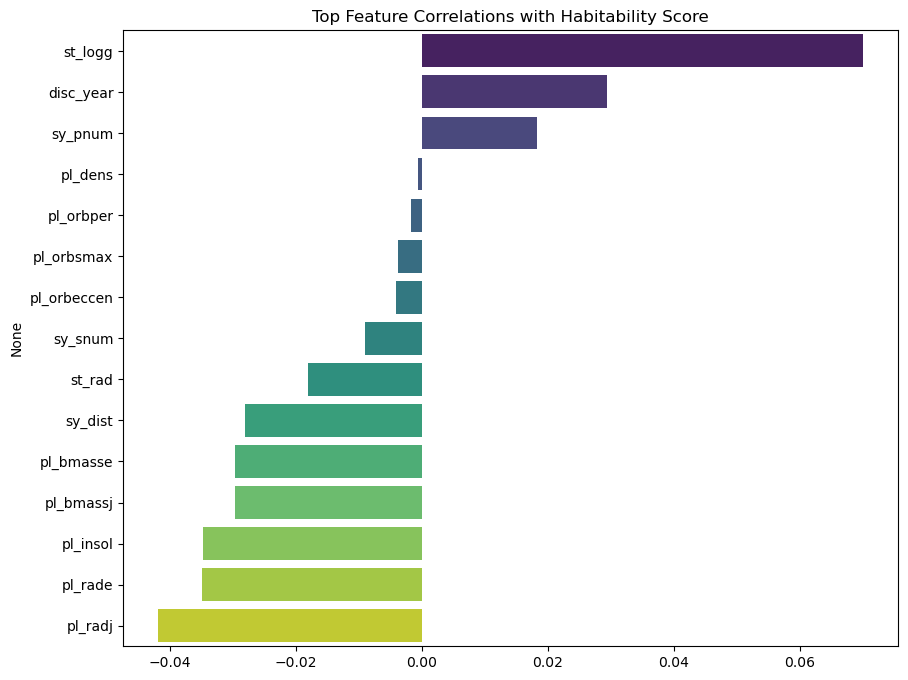

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('exoplanet_data.csv')

# Define Habitability Score and Class

df['pl_rade'] = df['pl_rade'].fillna(df['pl_rade'].median())
df['pl_eqt'] = df['pl_eqt'].fillna(df['pl_eqt'].median())
df['Habitability_Score'] = np.exp(-0.5 * (((df['pl_rade'] - 1) / 0.5)**2 + ((df['pl_eqt'] - 255) / 50)**2))

# Define target variable: Habitability class (1 if Score > 0.1, else 0)

threshold = 0.1
df['Habitability_Class'] = (df['Habitability_Score'] > threshold).astype(int)

#  Feature Selection based on correlation 
# Calculate correlation of numeric features with the target score
numeric_df = df.select_dtypes(include=[np.number])
correlations = numeric_df.corr()['Habitability_Score'].sort_values(ascending=False)
print("Correlations with Habitability Score:\n", correlations.head(10))

# Select features: We'll exclude the target variables and high-leverage calculation components
exclude = ['Habitability_Score', 'Habitability_Class', 'pl_rade', 'pl_eqt', 'pl_radj'] 
features = [col for col in numeric_df.columns if col not in exclude]

# Add categorical features
categorical_features = ['discoverymethod']
all_features = features + categorical_features

X = df[all_features]
y = df['Habitability_Class']

# Split Data (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

#  Create Data Pipeline
# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Full pipeline with feature selection
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)) # Select top 10 features
])

# Fit the pipeline on training data
X_train_processed = full_pipeline.fit_transform(X_train, y_train)
X_test_processed = full_pipeline.transform(X_test)

print("\nShape of processed training set:", X_train_processed.shape)
print("Shape of processed testing set:", X_test_processed.shape)

# Visualize Feature Correlation with Target Score
plt.figure(figsize=(10, 8))
top_corr = correlations.drop(['Habitability_Score', 'Habitability_Class']).head(15)
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title('Top Feature Correlations with Habitability Score')
plt.savefig('feature_correlations.png')

# Save processed data for modeling later if needed
train_df = pd.DataFrame(X_train_processed)
train_df['target'] = y_train.values
train_df.to_csv('final_train_set.csv', index=False)